# IFAT Interface Notebook

In [1]:
from brian2 import *
import matplotlib.pyplot as plt

%matplotlib inline
BrianLogger.suppress_hierarchy('brian2.codegen.generators.base')

## Define Functions

In [2]:
def calc_weight(M, alpha, mu, sigma):
    alpha = alpha/fF
    output = zeros((M,M))
    for i in np.arange(M):
        for j in np.arange(M):
            output[i,j] = exp(cos((2*pi*i/M) - (2*pi*j/M) - mu)/sigma**2)
    output = output * (alpha/np.max(output))
    output = 5.0 * np.around(output/(5.0))
    output[output==0.] = nan
    return output

In [3]:
def write_exc_syn(group, file):
    M = shape(group['weights'])
    with open(file,'w') as f:
        for i in range(M[0]):
            f.write('{}:'.format(i+30*34*group['stype']))
            for j in range(M[1]):
                if ~isnan(group['weights'][i,j]):
                    f.write(str(make_event(j, group['ttype'], int(group['weights'][i,j]/5), group['Em'])) + ' ')
            if i<M[0]-1:
                f.write('\n')

def write_inh_syn(i2e, i2i, file, append=False):
    M = shape(i2e['weights'])
    open_param  = 'a+' if append else 'w+'
    with open(file,open_param) as f:
        if append:
            f.write('\n')
        for i in range(M[0]):
            f.write('{}:'.format(i+30*34*i2e['stype']))
            for j in range(M[1]):
                if ~isnan(i2e['weights'][i,j]):
                    f.write(str(make_event(j, i2e['ttype'], int(i2e['weights'][i,j]/5), i2e['Em'])) + ' ')
                if ~isnan(i2i['weights'][i,j]):
                    f.write(str(make_event(j, i2i['ttype'], int(i2i['weights'][i,j]/5), i2i['Em'])) + ' ')
            if i<M[0]-1:
                f.write('\n')

In [4]:
def write_poisson_stim(time, spikes, file):
    count = 0
    with open(file, 'w') as f:
        for i, t in enumerate(time):
            f.write('{}:'.format(round(t/us)))
            for j in range(shape(spikes)[0]):
                if spikes[j,i]:
                    # this is currently specific, we can generalize it
                    f.write('{} '.format(make_event(j, 0, 5, 3)))
                    count += 1
            if i<len(time)-1:
                f.write('\n')
    print('Number of Poisson spikes:',count)

def make_spgen(timearray, spikes):
    N = sum(spikes)
    times = np.zeros(N)
    indices = np.zeros(N)
    count = 0
    for idx, time in enumerate(timearray):
        for ind in range(shape(spikes)[0]):
            if spikes[ind, idx]:
                times[count] = time/second
                indices[count] = ind
                count += 1
    return times*second, indices

In [5]:
def read_ifat_spikes(file, dt):
    dt = dt/second
    with open(file, 'r') as f:
        linecount = sum(1 for line in f)
    #inds = np.zeros(linecount)
    exc_sp = []
    exc_t  = []
    inh_sp = []
    inh_t  = []
    with open(file,'r') as f:
        for idx, line in enumerate(f):
            [row, col, addrx, count_hi, count_lo] = line.split()
            if idx == 0:
                offset_lo = int(count_lo)
            neuron = int(row)*30 + int(col)
            time = dt*(((1<<13)-1)*int(count_hi) + int(count_lo))# - offset_lo)
            
            if int(addrx):
                inh_sp.append(neuron)
                inh_t.append(time)
            else:
                exc_sp.append(neuron)
                exc_t.append(time)
    return asarray(exc_sp), asarray(exc_t), asarray(inh_sp), asarray(inh_t)

In [6]:
def make_event(index, addr_x, wm, em_sel, wt=0, chip_sel=1, thr_switch=0, debug=0):
    if(debug):
        print("\tMaking event..\n");

    wm_pos = 0;
    wt_pos = 5;
    row_pos = 10;
    col_pos = 16;
    em_sel_pos = 22;
    chip_sel_pos = 24;
    col_sel_pos = 28;
    addr_x_pos = 29;
    thr_switch_pos = 30;
    num_rows = 34;
    num_cols = 30;
    col_sel = 1;

    row = int(index/num_cols);
    col = int(index%num_cols)
    row_i = (row<<row_pos) & (0b11111<<row_pos);
    col_i = (col<<col_pos) & (0b11111<<col_pos);
    addrx_i = (addr_x<<addr_x_pos) & (0b11111<<addr_x_pos);
    wm_i = (wm<<wm_pos) & (0b11111<<wm_pos);
    wt_i = (wt<<wt_pos) & (0b11111<<wt_pos);
    em_i = (em_sel<<em_sel_pos) & (0b11111<<em_sel_pos);
    cs_i = (chip_sel<<chip_sel_pos) & (0b11111<<chip_sel_pos);
    col_sel_i = (col_sel<<col_sel_pos) & (0b11111<<col_sel_pos);
    thr_sw_i = (thr_switch<<thr_switch_pos) & (0b11111<<thr_switch_pos);

    out_event = row_i | col_i | addrx_i | wm_i | wt_i | em_i | cs_i | col_sel_i | thr_sw_i;
    out_event = out_event & 0xffffffff
    
    if(debug):
        print("\t\tout event:",end=' ')
        print(format(out_event, '032b'))

    return out_event;

In [7]:
def poissonSpikeGen(rate=3.0*kHz, dt=10.0*us, t=1*second, num_neur=1):
    bins = int(t/dt)
    #print(bins)
    output = rand(num_neur, bins) < rate*dt
    time = arange(0,t,dt)
    return time, output

## Begin Simulation

In [8]:
MODE = 'adaptive'
PARASITICS = True

In [9]:
# Define various equations

if MODE == 'adaptive':
    neuron_eq = '''
        dVm/dt = ((glm + gpar) / Cm) * (Vm_r - Vm)  : volt
        dVt/dt = ((glt + gpar) / Ct) * (Vt_r - Vt)  : volt
        
        # dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt
        # dVt/dt = (glt / Ct) * (Vt_r - Vt) : volt

        glm = flm * Cl                              : siemens
        glt = flt * Cl                              : siemens
        gpar = par_ctrl / par_leak_time * Cm : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
        Vt = Vt * (Vt > Vm) + Vt_r * (Vt <= Vm)
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
        Vt += (Cst/Ct) * (Vm_old - Vm_r)
    '''
else:
    neuron_eq = '''
        dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt

        glm = flm * Cl                    : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
    '''

# Synapse equation is the same for both modes!
syn_eq = '''
    Vsyn = (W/Cm)*(Em - Vm) : volt
    Em                      : volt
    W                       : farad
'''

In [10]:
# IFAT specific definitions
fF = 0.001 * pF
Vdd = 5 * volt
Cm = Ct = 440 * fF
Cl = 2 * fF

W_vals  = np.array([5, 10, 20, 40, 80]) * fF
Em_vals = np.array([0, 1/3, 2/3, 1]) * Vdd

par_ctrl = True
par_ctrl = float(PARASITICS)
par_leak_time = 12.5 * ms

# Model parameters
Vm_r = 1 * volt
flm  = 0 * kHz
Csm  = W_vals[0]

Vt_r = 3.5 * volt
flt  = 0 * MHz
Cst  = 0 * fF

M = 64

# Connectivity specifics
alpha = sum(W_vals)
mu1 = 0
mu2 = 2*pi/3
mu3 = pi
sigma = 36 * pi/180

In [11]:
bayo_dt = 75*us
bayo_time = 150*ms

Total number of Poisson spikes: 28511


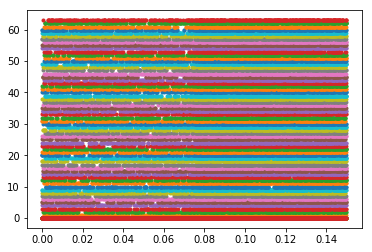

In [12]:
time_1, out_1 = poissonSpikeGen(rate=2*kHz, dt=bayo_dt, t=bayo_time/2, num_neur=M)
time_2, out_2 = poissonSpikeGen(rate=4*kHz, dt=bayo_dt, t=bayo_time/2, num_neur=M)
time_2 = time_2/second + bayo_time/(2*second)
time = concatenate((time_1,time_2))*second
out = concatenate((out_1, out_2),axis=1)

for idx in range(M):
    plot(time,out[idx]*idx,'.');

print('Total number of Poisson spikes: {}'.format(sum(out)))

times, indices = make_spgen(time, out)

In [13]:
start_scope()
defaultclock.dt = bayo_dt

G1 = NeuronGroup(2*M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
G1.Vt = Vt_r
G1.Vm = Vm_r
G1_exc = G1[:M]
G1_inh = G1[M:]

G1_e2i = Synapses(G1_exc, G1_inh, syn_eq, on_pre=presyn_eq)
W1_e2i = calc_weight(M,alpha,mu1,sigma)
for ii in range(M):
    for jj in range(M):
        if ~isnan(W1_e2i[ii,jj]):
            G1_e2i.connect(i=ii,j=jj)
G1_e2i.Em = Em_vals[3]
G1_e2i.W = W1_e2i[~isnan(W1_e2i)].flatten()*fF

G1_i2e = Synapses(G1_inh, G1_exc, syn_eq, on_pre=presyn_eq)
W1_i2e = calc_weight(M,alpha,mu2,sigma)
for ii in range(M):
    for jj in range(M):
        if ~isnan(W1_i2e[ii,jj]):
            G1_i2e.connect(i=ii,j=jj)
G1_i2e.Em = Em_vals[0]
G1_i2e.W = W1_i2e[~isnan(W1_i2e)].flatten()*fF

G1_i2i = Synapses(G1_inh, G1_inh, syn_eq, on_pre=presyn_eq)
W1_i2i = calc_weight(M,alpha/2,mu1,sigma)
for ii in range(M):
    for jj in range(M):
        if ~isnan(W1_i2i[ii,jj]):
            G1_i2i.connect(i=ii,j=jj)
G1_i2i.Em = Em_vals[0]
G1_i2i.W = W1_i2i[~isnan(W1_i2i)].flatten()*fF

P1 = SpikeGeneratorGroup(M, indices, times, sorted=True)
P1_syn = Synapses(P1, G1_exc, syn_eq, on_pre=presyn_eq)
P1_syn.connect('j==i')
P1_syn.Em = Em_vals[3]
P1_syn.W = W_vals[2] + W_vals[0]

G1e_sp = SpikeMonitor(G1_exc)
G1i_sp = SpikeMonitor(G1_inh)
G1e_v  = StateMonitor(G1_exc, 'Vm', record=True)
G1i_v  = StateMonitor(G1_inh, 'Vm', record=True)

In [14]:
run(bayo_time, report='text')

Starting simulation at t=0. s for a duration of 150. ms
0.15 (100%) simulated in < 1s


Text(0,0.5,'Neuron index')

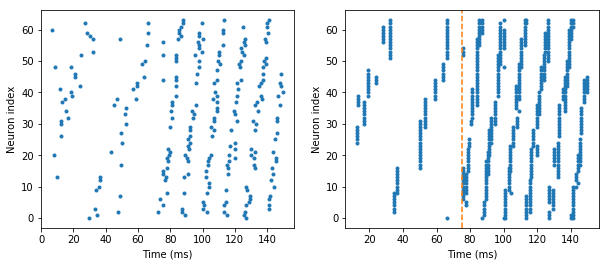

In [15]:
figure(figsize=(10,4))
subplot(121)
plot(G1e_sp.t/ms, G1e_sp.i,'.')
xlabel('Time (ms)')
ylabel('Neuron index')
#xlim([0,20])

subplot(122)
plot(G1i_sp.t/ms, G1i_sp.i,'.')
axvline(x=75,LineStyle='--',color='C1')
xlabel('Time (ms)')
ylabel('Neuron index')
#xlim([0,20])

## Load Outputs and Plot

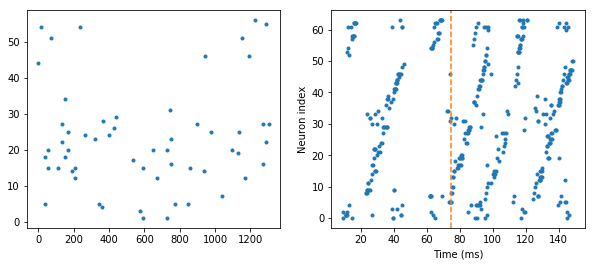

In [21]:
exc_sp, exc_t, inh_sp, inh_t = read_ifat_spikes('ifat_out/ifat_spikes_great_inh.txt',20*us)

figure(figsize=(10,4))
subplot(121)
plot(exc_t[exc_sp<100]*second/(ms), exc_sp[exc_sp<100],'.')
#catter(exc_t*second/(9*ms), exc_sp)

subplot(122)
#inh_t_pos = inh_t[inh_t>=0]; inh_sp_pos = inh_sp[inh_t>=0]
#scatter(inh_t_pos[inh_sp_pos<100]*second/(9*ms), inh_sp_pos[inh_sp_pos<100])
plot(inh_t[inh_sp<100]*second/(8.5*ms), inh_sp[inh_sp<100],'.')
#catter(inh_t*second/(9*ms), inh_sp)
xlabel('Time (ms)')
ylabel('Neuron index')
axvline(x=75,LineStyle='--',color='C1')
#ylim([0,64])

In [24]:
max(inh_t*second/(8.45*ms))

149.7869822485207

## Output connectivity and stim files

In [17]:
group1 = {'weights': W1_e2i, 'Em': 3, 'stype': 0, 'ttype': 1}
group2 = {'weights': W1_i2e, 'Em': 0, 'stype': 1, 'ttype': 0}
group3 = {'weights': W1_i2i, 'Em': 0, 'stype': 1, 'ttype': 1}

write_exc_syn(group1,'vco_conn.txt')
write_inh_syn(group2, group3, 'vco_conn.txt', append=True)

write_poisson_stim(time, out, 'vco_stim.txt')

Number of Poisson spikes: 28511
